# Performance of VGG16

In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

## Parameters and definitions

In [2]:
log_dir = '/home/rbodo/.snntoolbox/data/imagenet/vgg16/keras/maxpool/log'
runlabel_analog = '01'

clamp = 84 - 1

scale = 1e3  # Scale from Million to Billion operations

In [3]:
class ExpResults:
    def __init__(self, dirname, label, marker='.', color1='b', color5='r', markersize=4):
        self.dirname = dirname
        self.label = label
        self.marker = marker
        self.color1 = color1
        self.color5 = color5
        self.markersize = markersize
        self.time = None
        self.mean_computations_t = self.std_computations_t = None
        self.e1_mean = self.e1_std = self.e5_mean = self.e5_std = None
        self.set_spikestats()

    def set_spikestats(self):
        path = os.path.join(log_dir, 'gui', self.dirname, 'log_vars')
        num_batches = len(os.listdir(path))
        if num_batches == 0:
            return
        batch_size, num_timesteps = np.load(os.path.join(path, '0.npz'))['top1err_b_t'].shape
        self.time = np.arange(num_timesteps)
        num_frames_to_test = num_batches * batch_size
        e1 = np.empty((num_frames_to_test, num_timesteps))
        e5 = np.empty((num_frames_to_test, num_timesteps))

        # Load operation count
        operations_d_t = np.empty((num_frames_to_test, num_timesteps))
        for batch_idx in range(num_batches):
            operations_d_t[batch_idx*batch_size:(batch_idx+1)*batch_size] = \
                np.load(os.path.join(path, str(batch_idx)+'.npz'))['operations_b_t'] / scale
        self.mean_computations_t = np.mean(operations_d_t, 0)
        self.std_computations_t = np.std(operations_d_t, 0)

        # Load error
        for batch_idx in range(num_batches):
            e1[batch_idx*batch_size: (batch_idx+1)*batch_size] = \
                np.multiply(100, np.load(os.path.join(path, str(batch_idx)+'.npz'))['top1err_b_t'])
            e5[batch_idx*batch_size: (batch_idx+1)*batch_size] = \
                np.multiply(100, np.load(os.path.join(path, str(batch_idx)+'.npz'))['top5err_b_t'])
        
        # Averaged across samples, shape (1, num_timesteps)
        self.e1_mean = np.mean(e1, axis=0)
        self.e1_std = np.std(e1, axis=0)
        self.e5_mean = np.mean(e5, axis=0)
        self.e5_std = np.std(e5, axis=0)
        
        
def get_std(err):
    return np.sqrt(err*(100-err))

## Performance of ANN and NHP

In [4]:
# Error and number of operations
top1err_ANN = 100 - 64.27
top1std_ANN = get_std(top1err_ANN)
top5err_ANN = 100 - 85.59
top5std_ANN = get_std(top5err_ANN)
c_ANN = 30940528640 / 1e9

## Plot number of operations vs time

In [5]:
exp_analog = ExpResults(runlabel_analog, 'SNN', '-.')
experiments = [exp_analog]

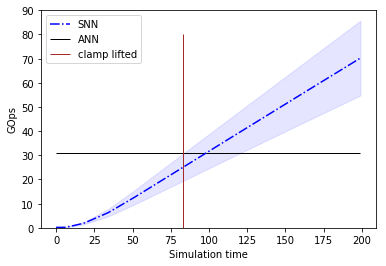

In [6]:
for exp in experiments:
    plt.plot(exp.time, exp.mean_computations_t, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.mean_computations_t-exp.std_computations_t, exp.mean_computations_t+exp.std_computations_t, alpha=0.1, color=exp.color1)
plt.hlines(c_ANN, 0, experiments[0].time[-1], linewidth=1, label='ANN')
plt.vlines(clamp, 0, 80, linewidth=1, label='clamp lifted', colors='brown')
plt.ylabel('GOps')
plt.xlabel('Simulation time')
plt.legend()
plt.ylim(0, None)
plt.savefig(os.path.join(log_dir, 'ops_vs_t'), bbox_inches='tight')

## Plot error vs time

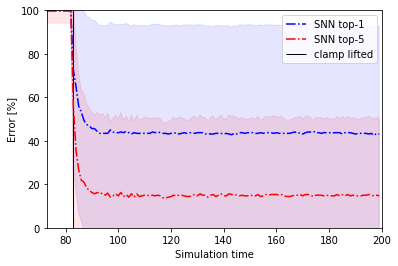

In [7]:
for exp in experiments:
    plt.plot(exp.time, exp.e1_mean, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label+' top-1')
    plt.fill_between(exp.time, exp.e1_mean-exp.e1_std, exp.e1_mean+exp.e1_std, alpha=0.1, color=exp.color1)
    plt.plot(exp.time, exp.e5_mean, exp.marker, color=exp.color5, markersize=exp.markersize, label=exp.label+' top-5')
    plt.fill_between(exp.time, exp.e5_mean-exp.e5_std, exp.e5_mean+exp.e5_std, alpha=0.1, color=exp.color5)
plt.vlines(clamp, 0, 100, linewidth=1, label='clamp lifted')
plt.ylabel('Error [%]')
plt.xlabel('Simulation time')
plt.xlim(clamp-10, 200)
plt.ylim(0, 100)
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_t'), bbox_inches='tight')

## Plot error vs operations

In [21]:
def get_op_at_err(ops_t, err_SNN, err_ANN):
    t = np.where(err_SNN <= err_ANN)[0][0]
    return ops_t[t]

In [35]:
op1_8 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e1_mean, top1err_ANN + 8)
op5_1 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e5_mean, top5err_ANN + 1)
op5_2 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e5_mean, top5err_ANN + 2)
print("SNN reaches within 1% of ANN top-5 error after {:.2f} GOps.".format(op5_1))

SNN reaches within 1% of ANN top-5 error after 29.74 GOps.


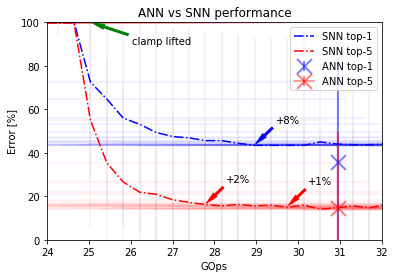

In [48]:
exp = experiments[0]
plt.errorbar(exp.mean_computations_t, exp.e1_mean, xerr=exp.std_computations_t,
             yerr=exp.e1_std, fmt=exp.marker, label=exp.label+' top-1', capsize=0, elinewidth=0.1, color=exp.color1)
plt.errorbar(exp.mean_computations_t, exp.e5_mean, xerr=exp.std_computations_t,
             yerr=exp.e5_std, fmt=exp.marker, label=exp.label+' top-5', capsize=0, elinewidth=0.1, color=exp.color5)

plt.errorbar(c_ANN, top1err_ANN, yerr=top1std_ANN, fmt='x', label='ANN top-1', color=exp.color1, markersize=15,
             elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
plt.errorbar(c_ANN, top5err_ANN, yerr=top5std_ANN, marker='x', label='ANN top-5', color=exp.color5, markersize=15,
             elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
plt.annotate('clamp lifted', xy=(experiments[0].mean_computations_t[clamp], 100), xytext=(experiments[0].mean_computations_t[clamp] + 1, 90),
             arrowprops=dict(color='green', shrink=0.05, width=2, headwidth=5))
plt.annotate('+8%', xy=(op1_8, top1err_ANN+8), xytext=(op1_8 + 0.5, top1err_ANN + 18),
             arrowprops=dict(color=exp.color1, shrink=0.05, width=2, headwidth=5))
plt.annotate('+1%', xy=(op5_1, top5err_ANN+1), xytext=(op5_1 + 0.5, top5err_ANN + 11),
             arrowprops=dict(color=exp.color5, shrink=0.05, width=2, headwidth=5))
plt.annotate('+2%', xy=(op5_2, top5err_ANN+2), xytext=(op5_2 + 0.5, top5err_ANN + 12),
             arrowprops=dict(color=exp.color5, shrink=0.05, width=2, headwidth=5))

plt.ylim(0, 100)
plt.xlim(24, 32)
plt.ylabel('Error [%]')
plt.xlabel('GOps')
plt.legend(loc='upper right')
plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')